In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TWA_Design_Tools import TWA_Design_Toolkit

In [2]:
# Enter the physical parameters of the antenna 
num_straps = 8
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

myTWA = TWA_Design_Toolkit(num_straps=num_straps, f0=f0, k_par_max=k_par)
myTWA.print_key_params()

# set my antenna width to 50% of the distance between straps 
myTWA.set_strap_width(w=8e-2)
print(f'Strap width: {myTWA.wstr*100} cm')




k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
You are at resonance, so delta_phi = pi/2. Solving for d given k_par:


----------------Parameter--Box-------------------
Distance between strap centers d = 0.15625 m
The first null will be at 5.026548245743669 m^-1
delta_phi = -0.5 pi
Strap length should be less than lambda/4 = 0.7807095260416667 m
--------------END--Parameter--Box----------------


The antenna length is 1.17375 m long
Strap width: 8.0 cm


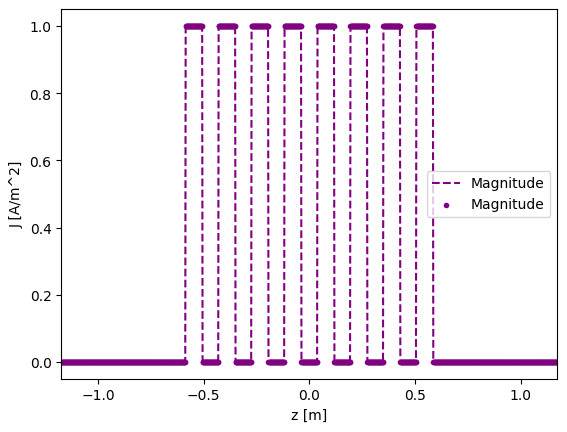

In [3]:
# Confirm that the spectrum is set up correctly 

zrange = 100
num_points = int(1e5) # number of grid points for the z grid
zlim = 2*(num_straps*myTWA.wstr + (num_straps-1)*(myTWA.d - myTWA.wstr))/2
plt.xlim(-zlim, zlim)
myTWA.plot_J_of_z(J0=1, zmin=-zrange, zmax=zrange, num_points=num_points)

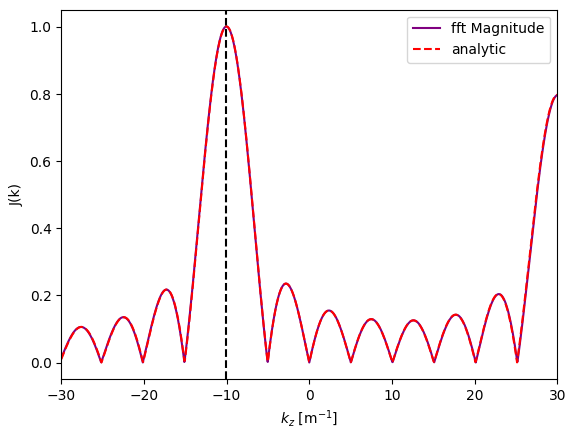

In [4]:
# now, plot the fourier spectrum of power over the k_par number 
myTWA.plot_J_k_versus_k(zmin=-zrange, zmax=zrange, kplotmin=-30, kplotmax=30, num_pointsz=num_points, num_pointsk=1000, J0=1)

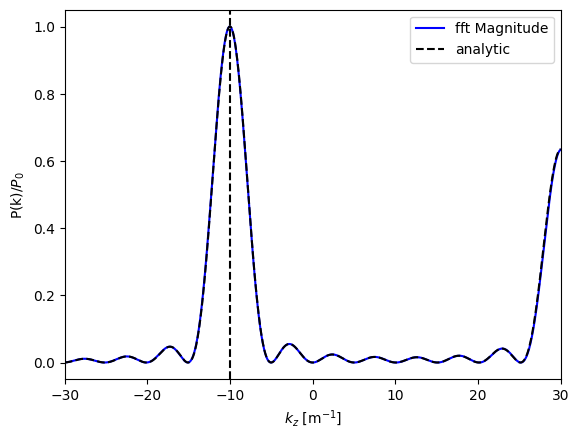

In [5]:
myTWA.plot_normalized_power_versus_k(zmin=-zrange, zmax=zrange, kplotmin=-30, kplotmax=30, num_pointsz=num_points, num_pointsk=1000, J0=1)

In [6]:
print(myTWA.delta_phi)
print(myTWA.w0)
print(myTWA.d)
print(myTWA.k_par_max)

-1.5707963267948966
603185789.4892403
0.15625
-10.053096491487338


The port characteristic impedence is Z0 = 83.12100040448948
C0 =  -11.111129650362718  pF
w: 0.08
h2: 0.002
l: -0.031373191919930876
d: 0.15625
Zav:  -149.2075101910503
C0check:  -1.1111129650362719e-11


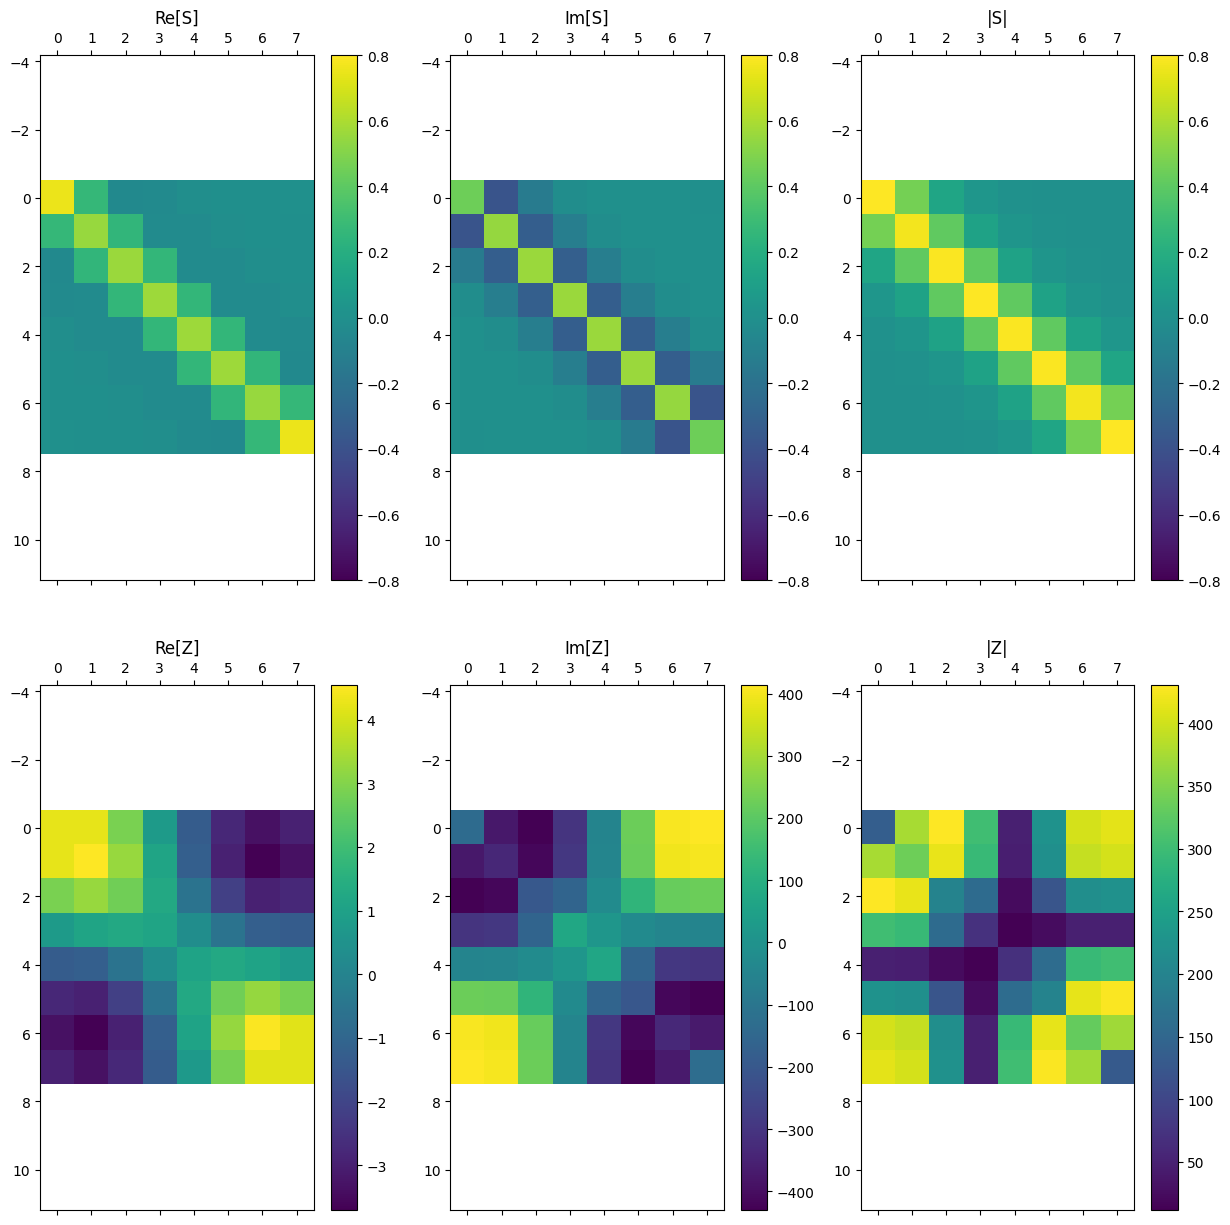

In [7]:
## S and Z matrix Section 

Smatrix_file_name = 'S_matrix.csv'
Smat = myTWA.read_Smat_from_comsol_portscan_Stable(filename=Smatrix_file_name, return_flag=True)

Z0 = myTWA.get_coax_Z0(d_outer=0.016, d_inner=0.004)
myTWA.get_Z_matrix(Z0_port=Z0)
print(f'The port characteristic impedence is Z0 = {Z0}')
print('C0 = ', myTWA.calculate_C0()/1e-12, ' pF')

h = .01
h2 = h/5
w = myTWA.wstr
print(f'w: {w}')
print(f'h2: {h2}')
A = myTWA.cap_area_given_gap(h2)
l = A/w
print(f'l: {l}')
print(f'd: {myTWA.d}')

Zav = np.trace(np.imag(myTWA.Zmatrix))/8
C0check = 1/(Zav*w0)
print('Zav: ', Zav)
print('C0check: ', C0check)
myTWA.plot_Smat_and_Zmat()

 




In [8]:
np.savetxt('Smat_testing_R.txt',np.real(Smat))
np.savetxt('Smat_testing_I.txt',np.imag(Smat))

-149.2075101910503

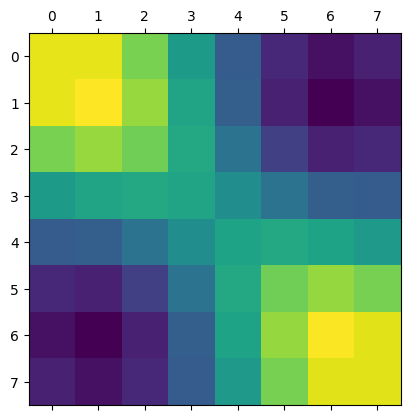

In [9]:
smat_size = Smat.shape[0]  # get the shape of the S matrix
I = np.identity(smat_size, dtype=complex)
Zmatrix = Z0*np.matmul((I + Smat),np.linalg.inv(I - Smat))
plt.matshow(np.real(Zmatrix))
np.trace(np.imag(Zmatrix))/8

In [10]:
import skrf as rf

(1, 8, 8)


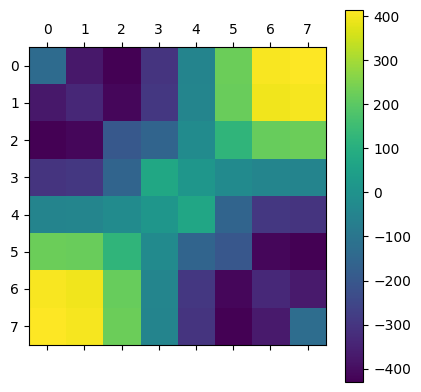

In [11]:
S = np.array([Smat])
print(S.shape)
Zmat = rf.s2z(S, Z0)[0]
plt.matshow(np.imag(Zmat))
plt.colorbar()

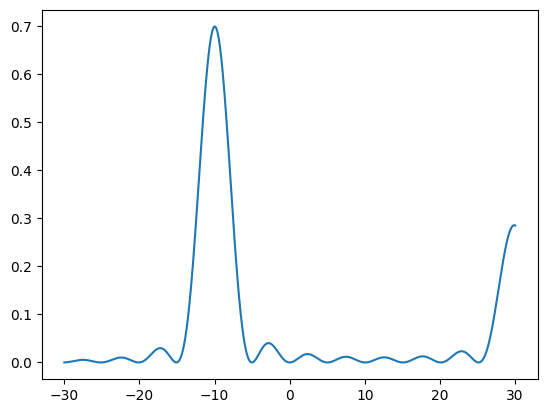

In [12]:
W = 10.9375/100
w0 = f0*2*np.pi
c = 3e8
delta_phi = np.pi/2
d = 0.15625

def get_fft_analytic(k, P0):
    n = k*c/(w0) # TODO why is this negative? 
    if n == 0:
        return 1*P0
    else:
        term1 = np.sin(n*W*w0/(2*c))**2 / n**2
        alpha = delta_phi + n*w0*d/c
        # alpha = self.delta_phi + n*self.w0*self.d/self.clight
        term2 = np.sin(num_straps*alpha/2)**2/np.sin(alpha/2)**2
        return P0*term1 * term2
    
karray = np.linspace(-30, 30, 1000)
anyarray = np.zeros_like(karray)
for i in range(karray.shape[0]):
    anyarray[i] = get_fft_analytic(karray[i], 1)

plt.plot(karray, anyarray)